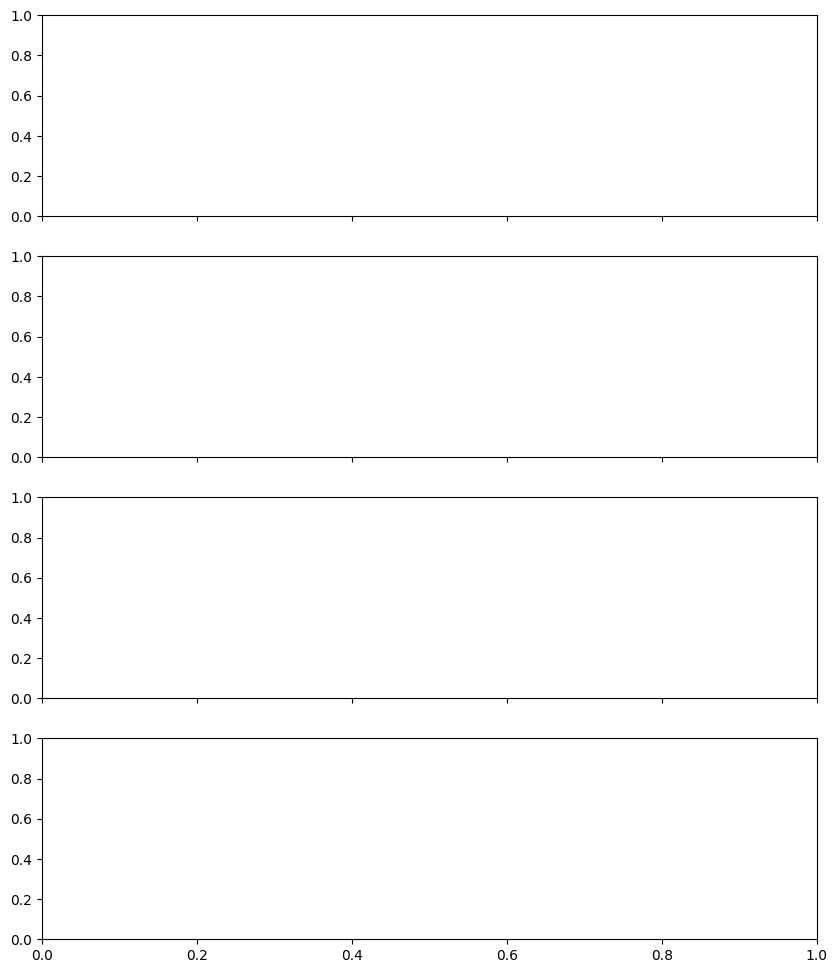

In [9]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open("carla_debug_0.pkl", "rb") as f:
    data = pickle.load(f)

steps = data["steps"]                       # (T,)
ego_raw = data["ego_raw"]                  # (T, 6)
disc = data["disc_actions"]                # (T,)
decoded = data["decoded_actions"]          # (T, 3)

speed      = ego_raw[:, 0]
veh_len    = ego_raw[:, 1]
veh_width  = ego_raw[:, 2]
rel_x      = ego_raw[:, 3]
rel_y      = ego_raw[:, 4]
collided   = ego_raw[:, 5]

throttle = decoded[:, 0]
steer    = decoded[:, 1]
brake    = decoded[:, 2]

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 12))

In [10]:
disc

array([82., 63., 68., 68., 63., 63., 74., 75., 63., 68., 82., 63., 63.,
       63., 70., 68., 34., 68., 68., 82., 82., 63.,  4., 84., 82., 83.,
       82., 31., 35., 82., 63., 82., 82., 22., 89.,  4., 82., 68., 84.,
       82., 82., 63., 83., 82., 82., 89., 88., 82., 24.,  4., 82.,  4.,
       82., 82., 82., 82.,  4.,  4., 82.,  4.,  4.,  4., 31.,  4., 74.,
       82., 31., 82., 74., 88.,  4.,  4.,  4., 82., 82., 82., 68., 82.,
       82.,  4., 35.,  4.,  4.,  4., 82.,  4., 82.,  4., 82., 82.,  4.,
       82., 74., 82., 73.,  4., 82.,  4.,  4.,  4.,  4., 82.,  4., 82.,
       49., 82.,  4.,  4., 82.,  4.,  4.,  4.,  4.,  4., 63., 89., 75.,
       82., 63., 10., 83., 76., 82., 82., 49., 35., 89., 82., 75.,  4.,
       74., 82.,  4.,  4.,  4., 82.,  4.,  4., 23.,  4., 82., 63., 82.,
       75., 82., 88., 75., 82., 88., 82.,  4.,  4.,  4.,  4., 75.,  4.,
       76., 74., 82.,  4., 82.,  4.,  4., 82., 82.,  4., 82.,  4.,  4.,
       82., 76., 82., 75., 49.,  4., 68.,  4.,  4., 82., 82., 82

In [11]:
decoded

array([[ 0.64999998,  0.83333331,  0.        ],
       [ 0.        ,  0.5       ,  1.        ],
       [ 0.64999998,  0.5       ,  0.        ],
       [ 0.64999998,  0.5       ,  0.        ],
       [ 0.        ,  0.5       ,  1.        ],
       [ 0.        ,  0.5       ,  1.        ],
       [ 0.32499999,  0.66666669,  0.        ],
       [ 0.64999998,  0.66666669,  0.        ],
       [ 0.        ,  0.5       ,  1.        ],
       [ 0.64999998,  0.5       ,  0.        ],
       [ 0.64999998,  0.83333331,  0.        ],
       [ 0.        ,  0.5       ,  1.        ],
       [ 0.        ,  0.5       ,  1.        ],
       [ 0.        ,  0.5       ,  1.        ],
       [ 0.        ,  0.66666669,  1.        ],
       [ 0.64999998,  0.5       ,  0.        ],
       [ 1.        , -0.33333334,  0.        ],
       [ 0.64999998,  0.5       ,  0.        ],
       [ 0.64999998,  0.5       ,  0.        ],
       [ 0.64999998,  0.83333331,  0.        ],
       [ 0.64999998,  0.83333331,  0.   

In [12]:
82//13

6

In [27]:
STEER_BINS = np.linspace(-np.pi, np.pi, 13)   # 13 values
ACCEL_BINS = np.array([-4.0, -2.6, -1.3, 0.0, 1.3, 2.6, 4.0])  # 7 values

def decode_discrete_action(discrete_action: np.ndarray) -> np.ndarray:
        """
        Converts discrete GPUDrive action(s) into CARLA continuous control:
            throttle, steer, brake

        discrete_action: shape () for 1 agent or (N,)
        returns: (N, 3)
        """
        act = np.asarray(discrete_action)

        # Case 1: scalar → convert to (1,)
        if act.ndim == 0:
            act = np.array([act.item()], dtype=np.int64)

        # Shape (N,)
        N = act.shape[0]

        # Steering index: integer in [0, 12]
        steer_idx = int(act % len(STEER_BINS))
        print(f"steering index {steer_idx}")

        # Acceleration index: integer in [0, 6]
        accel_idx = int(act // len(STEER_BINS))
        print(f"accel index {accel_idx}")
        
        # Map to actual continuous values
        steer = STEER_BINS[steer_idx]              # radians
        accel = ACCEL_BINS[accel_idx]              # m/s^2 roughly

        # Convert accel → throttle/brake
        throttle = np.clip(accel, 0, None) / 4.0   # scale 0..4 → 0..1
        brake    = np.clip(-accel, 0, None) / 4.0  # scale -4..0 → 0..1

        # Normalize steering from [-pi, pi] to [-1, 1]
        steer_norm = steer / np.pi

        return np.stack([throttle, steer_norm, brake], axis=-1).astype(np.float32)

In [28]:
for item in disc:
    decode_discrete_action(item)

steering index 4
accel index 6
steering index 11
accel index 4
steering index 3
accel index 5
steering index 3
accel index 5
steering index 11
accel index 4
steering index 11
accel index 4
steering index 9
accel index 5
steering index 10
accel index 5
steering index 11
accel index 4
steering index 3
accel index 5
steering index 4
accel index 6
steering index 11
accel index 4
steering index 11
accel index 4
steering index 11
accel index 4
steering index 5
accel index 5
steering index 3
accel index 5
steering index 8
accel index 2
steering index 3
accel index 5
steering index 3
accel index 5
steering index 4
accel index 6
steering index 4
accel index 6
steering index 11
accel index 4
steering index 4
accel index 0
steering index 6
accel index 6
steering index 4
accel index 6
steering index 5
accel index 6
steering index 4
accel index 6
steering index 5
accel index 2
steering index 9
accel index 2
steering index 4
accel index 6
steering index 11
accel index 4
steering index 4
accel index 